## Model Selection using RFE(HOUSING CASE STUDY)

## RFE(Recursive Feature Elimination)

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

## What is RFE

Datasets used to train classification and regression algorithms are high dimensional in nature — this means that they contain many features or attributes. In textual datasets each feature is a word and as you can imagine the vocabulary used in the dataset can be very large. Not all features however, contribute to the prediction variable. Removing features of low importance can improve accuracy, and reduce both model complexity and overfitting. Training time can also be reduced for very large datasets. In this blog post performing Recursive Feature Elimination (RFE) with Scikit Learn will be covered.

**Not all features are created equally so rank and eliminate!**


Recursive Feature Elimination (RFE) as its title suggests recursively removes features, builds a model using the remaining attributes and calculates model accuracy. RFE is able to work out the combination of attributes that contribute to the prediction on the target variable (or class). Scikit Learn does most of the heavy lifting just import RFE from sklearn.feature_selection and pass any classifier model to the RFE() method with the number of features to select. Using familiar Scikit Learn syntax, the .fit() method must then be called.


In [1]:
import pandas as pd
import numpy as np


In [2]:
# Importing Housing.csv
housing = pd.read_csv('Housing.csv')

# Looking at the first five rows
housing.head()

price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished

### Data Preparation

In [3]:
# Converting Yes to 1 and No to 0
housing['mainroad'] = housing['mainroad'].map({'yes': 1, 'no': 0})
housing['guestroom'] = housing['guestroom'].map({'yes': 1, 'no': 0})
housing['basement'] = housing['basement'].map({'yes': 1, 'no': 0})
housing['hotwaterheating'] = housing['hotwaterheating'].map({'yes': 1, 'no': 0})
housing['airconditioning'] = housing['airconditioning'].map({'yes': 1, 'no': 0})
housing['prefarea'] = housing['prefarea'].map({'yes': 1, 'no': 0})



In [4]:
# Creating dummy variable for variable furnishingstatus and dropping the first one
status = pd.get_dummies(housing['furnishingstatus'],drop_first=True)

#Adding the results to the master dataframe
housing = pd.concat([housing,status],axis=1)

# Dropping the variable 'furnishingstatus'
housing.drop(['furnishingstatus'],axis=1,inplace=True)

#### Creating a new variable

In [5]:
# Let us create the new metric and assign it to "areaperbedroom"
housing['areaperbedroom'] = housing['area']/housing['bedrooms']

# Metric: bathrooms per bedroom
housing['bbratio'] = housing['bathrooms']/housing['bedrooms']

### Rescaling the Features 
It is extremely important to rescale the variables so that they have a comparable scale. 
There are twocoon ways of rescaling 
1. Normalisation (min-max scaling) and 
2. standardisation (mean-o, sigma-1) 
Let's try normalisation

In [6]:
#defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                            
                                              
# applying normalize ( ) to all columns 
housing = housing.apply(normalize)

In [7]:
housing.head()

price      area  bedrooms  bathrooms   stories  mainroad  guestroom  \
0  1.000000  0.396564       0.6   0.333333  0.666667       1.0        0.0   
1  0.909091  0.502405       0.6   1.000000  1.000000       1.0        0.0   
2  0.909091  0.571134       0.4   0.333333  0.333333       1.0        0.0   
3  0.906061  0.402062       0.6   0.333333  0.333333       1.0        0.0   
4  0.836364  0.396564       0.6   0.000000  0.333333       1.0        1.0   

   basement  hotwaterheating  airconditioning   parking  prefarea  \
0       0.0              0.0              1.0  0.666667       1.0   
1       0.0              0.0              1.0  1.000000       0.0   
2       1.0              0.0              0.0  0.666667       1.0   
3       1.0              0.0              1.0  1.000000       1.0   
4       1.0              0.0              1.0  0.666667       0.0   

   semi-furnished  unfurnished  areaperbedroom  bbratio  
0             0.0          0.0        0.237016      0.4  
1             0.0          0.0        0.298923      1.0  
2             1.0          0.0        0.472584      0.6  
3             0.0          0.0        0.240232      0.4  
4             0.0          0.0        0.237016      0.1

### Splitting data into training and testing sets

In [8]:
# Putting feature variable to X
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio']]

# Putting response variable to y
y = housing['price']

In [9]:
#random_state is the seed used by the random number generator, it can be any integer.
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

In [10]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### RFE

In [11]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [12]:
# Running RFE with the output number of the variable equal to 9
lm = LinearRegression()
rfe = RFE(lm, 9)             # running RFE
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)  

[ True False  True  True  True False False  True  True False  True False
 False  True  True]
[1 3 1 1 1 4 6 1 1 2 1 7 5 1 1]


In [13]:
col = X_train.columns[rfe.support_]
print(col)

Index(['area', 'bathrooms', 'stories', 'mainroad', 'hotwaterheating',
       'airconditioning', 'prefarea', 'areaperbedroom', 'bbratio'],
      dtype='object')


### Building model using sklearn

In [14]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [15]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

C:\Users\ritesharyan\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     80.14
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           1.88e-81
Time:                        12:31:08   Log-Likelihood:                 369.54
No. Observations:                 381   AIC:                            -719.1
Df Residuals:                     371   BIC:                            -679.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0139      0.021     

In [17]:
# Calculating Vif value
vif_cal(input_data=housing.drop(['area','bedrooms','stories','basement','semi-furnished','areaperbedroom'], axis=1), dependent_col="price")

Var   Vif
8          bbratio  6.21
1         mainroad  4.66
0        bathrooms  2.78
5          parking  1.82
4  airconditioning  1.59
7      unfurnished  1.44
6         prefarea  1.41
2        guestroom  1.28
3  hotwaterheating  1.08

## Making Predictions

In [18]:
# Now let's use our model to make predictions.

# Creating X_test_6 dataframe by dropping variables from X_test
X_test_rfe = X_test[col]

# Adding a constant variable 
X_test_rfe = sm.add_constant(X_test_rfe)

# Making predictions
y_pred = lm.predict(X_test_rfe)

C:\Users\ritesharyan\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Model Evaluation

In [19]:
# Now let's check how well our model is able to make predictions.

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0, 0.5, 'Housing Price')

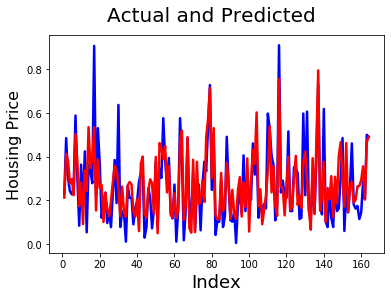

In [20]:
# Actual and Predicted
import matplotlib.pyplot as plt
c = [i for i in range(1,165,1)] # generating index 
fig = plt.figure() 
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Housing Price', fontsize=16)                       # Y-label

Text(0, 0.5, 'ytest-ypred')

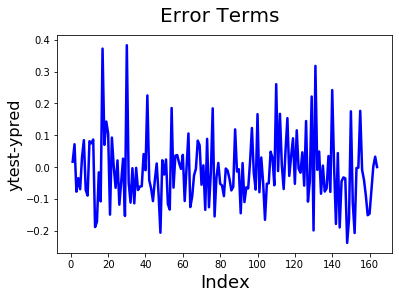

In [21]:
# Error terms
c = [i for i in range(1,165,1)]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label

Text(0, 0.5, 'y_pred')

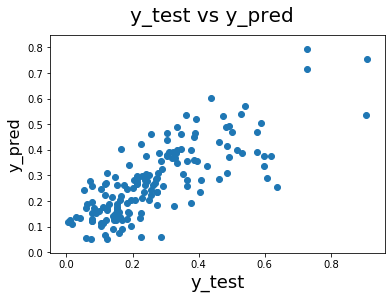

In [22]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

Text(0, 0.5, 'Index')

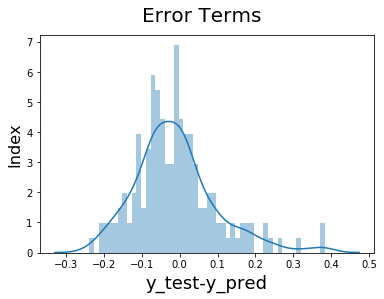

In [23]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

In [24]:
# Now let's check the Root Mean Square Error of our model.
import numpy as np
from sklearn import metrics
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.10820352538131711
